# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [4]:
set_plot_sizes(12,14,16)

In [5]:
!tree ../

../
├── Dockerfile
├── HISTORY
├── R2-Lecture-Notes.pdf
├── README.md
├── app.py
├── fastai
│   ├── AUTHORS.md
│   ├── CHANGES.md
│   ├── CLA.md
│   ├── CODE-OF-CONDUCT.md
│   ├── CONTRIBUTING.md
│   ├── LICENSE
│   ├── MANIFEST.in
│   ├── Makefile
│   ├── README.md
│   ├── azure-pipelines.yml
│   ├── builds
│   │   ├── custom-conda-builds
│   │   │   ├── README.md
│   │   │   ├── dataclasses
│   │   │   │   └── meta.yaml
│   │   │   ├── torchvision
│   │   │   │   └── meta.yaml
│   │   │   └── torchvision-cpu
│   │   │       └── meta.yaml
│   │   └── custom-pip-builds
│   │       └── torchvision
│   │           ├── README.md
│   │           └── setup.py
│   ├── conda
│   │   └── meta.yaml
│   ├── conftest.py
│   ├── courses
│   │   ├── dl1
│   │   │   ├── adamw-sgdw-demo.ipynb
│   │   │   ├── cifar10-simplenet.ipynb
│   │   │   ├── cifar10.ipynb
│   │   │   ├── embedding_refactoring_unit_tests.ipynb
│   │   │   ├── excel
│   │   │   │   ├── collab_filter.xlsx
│   │   │   │   ├── conv-

│   │           │   │   │   ├── __pycache__
│   │           │   │   │   │   ├── __init__.cpython-36.pyc
│   │           │   │   │   │   ├── _cmd.cpython-36.pyc
│   │           │   │   │   │   ├── adapter.cpython-36.pyc
│   │           │   │   │   │   ├── cache.cpython-36.pyc
│   │           │   │   │   │   ├── compat.cpython-36.pyc
│   │           │   │   │   │   ├── controller.cpython-36.pyc
│   │           │   │   │   │   ├── filewrapper.cpython-36.pyc
│   │           │   │   │   │   ├── heuristics.cpython-36.pyc
│   │           │   │   │   │   ├── serialize.cpython-36.pyc
│   │           │   │   │   │   └── wrapper.cpython-36.pyc
│   │           │   │   │   ├── _cmd.py
│   │           │   │   │   ├── adapter.py
│   │           │   │   │   ├── cache.py
│   │           │   │   │   ├── caches
│   │           │   │   │   │   ├── __init__.py
│   │           │   │   │   │   ├── __pycache__
│   │           │   │   │   │   │   ├── __init__.cpython-36.pyc
│   │           │   │   │   │   │   

│       │   │   │   ├── zeiler3.png
│       │   │   │   └── zeiler4.png
│       │   │   ├── keras_lesson1.ipynb
│       │   │   ├── lang_model-arxiv.ipynb
│       │   │   ├── lang_model.ipynb
│       │   │   ├── lesson1-breeds.ipynb
│       │   │   ├── lesson1-rxt50.ipynb
│       │   │   ├── lesson1-vgg.ipynb
│       │   │   ├── lesson1.ipynb
│       │   │   ├── lesson2-image_models.ipynb
│       │   │   ├── lesson3-rossman.ipynb
│       │   │   ├── lesson4-imdb.ipynb
│       │   │   ├── lesson5-movielens.ipynb
│       │   │   ├── lesson6-rnn.ipynb
│       │   │   ├── lesson6-sgd.ipynb
│       │   │   ├── lesson7-CAM.ipynb
│       │   │   ├── lesson7-cifar10.ipynb
│       │   │   ├── nasnet.ipynb
│       │   │   ├── nlp-arxiv.ipynb
│       │   │   ├── nlp.ipynb
│       │   │   ├── planet.py
│       │   │   ├── planet_cv.ipynb
│       │   │   ├── ppt
│       │   │   │   └── lesson6.pptx
│       │   │   ├── rossman_exp.py
│       │   │   ├── scripts
│       │   │   │   └── train_planet.p

In [6]:
!ls tmp/bulldozers-raw

tmp/bulldozers-raw


In [7]:
#Load data 

PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [8]:
y_trn

array([11.09741, 10.95081,  9.21034, ...,  9.3501 ,  9.10498,  8.95545])

In [9]:
#This is from the lecture - first run of RandomForest

m = RandomForestRegressor(n_jobs=-1)
m.fit(df_trn, y_trn)
m.score(df_trn, y_trn)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9831723889894296

In [10]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [11]:
#Start tracking using RMSE - as thats what Kaggle is using to judge

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [12]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


In [13]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 10s, sys: 852 ms, total: 1min 10s
Wall time: 47.5 s
[0.09060711794818271, 0.2503324846380693, 0.9828422846284509, 0.8880865217326678]


In [ ]:
#TODO - add the sampling code here - to take random samples of 20K

In [14]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)
#score from - [0.09060711794818271, 0.2503324846380693, 0.9828422846284509, 0.8880865217326678]
#score to - [0.5371269683343528, 0.5674541015387189, 0.3970396664995466, 0.4249449087372119]
#TODO - what do each of those numbers mean above? 

[0.5371269683343528, 0.5674541015387189, 0.3970396664995466, 0.4249449087372119]


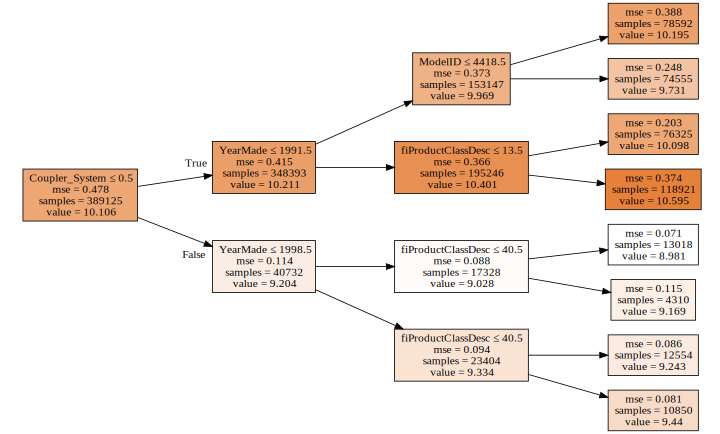

In [16]:
#  brew install graphviz

draw_tree(m.estimators_[0], df_trn, precision=3)

In [ ]:
#Changes Scikit learn's random forests to give each tree a random sample of n random rows.

set_rf_samples(50000)


In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
#Todo - put in the R^2 notes right here - so the coexist

In [ ]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

In [ ]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

In [ ]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [ ]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

In [ ]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

In [ ]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

In [ ]:
raw_valid.ProductSize.value_counts().plot.barh();

In [ ]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

In [ ]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

In [ ]:
fi = rf_feat_importance(m, df_trn); fi[:10]

In [ ]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [ ]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

In [ ]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [ ]:
from scipy.cluster import hierarchy as hc

In [ ]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [ ]:
get_oob(df_keep)

In [ ]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

In [ ]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

In [ ]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [ ]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [ ]:
plot_pdp('YearMade')

In [ ]:
plot_pdp('YearMade', clusters=5)

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

In [ ]:
contributions[0].sum()

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

In [ ]:
(X_valid[feats]/1000).describe()

In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)